In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from load_datasets import load_all_datasets
from autoencoders.attention_autoencoder import AttentionAutoencoder
from autoencoders.transformer_autoencoder import TransformerAutoencoder
from utils import *
from torchviz import make_dot, make_dot_from_trace
from mpl_toolkits import mplot3d
from autoencoders.all_to_all_autoencoder import AllToAllAutoencoder
from autoencoders.transformer_autoencoder import TransformerAutoencoder
from autoencoders.attention_autoencoder import AttentionAutoencoder

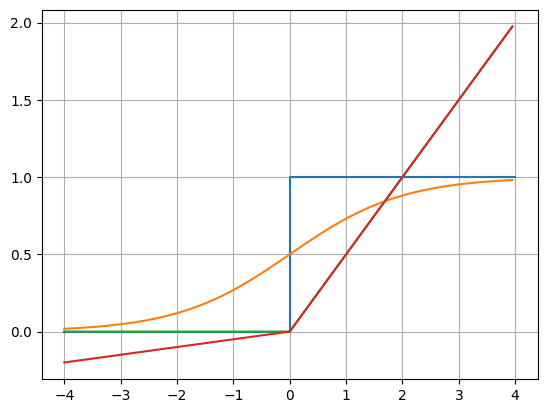

In [2]:
x = np.arange(-4, 4, 0.05)
y_small = np.arange(-2, 2, 0.025)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.where(x>0,x,0)

def leaky_relu(x):
    return np.where(x>0,x,0.1*x)


fig, ax = plt.subplots()
ax.grid()
ax.plot([-4, 0, 0, 4], [0, 0, 1, 1])
ax.plot(x, sigmoid(x))
ax.plot(x, relu(y_small))
ax.plot(x, leaky_relu(y_small))

plt.show()

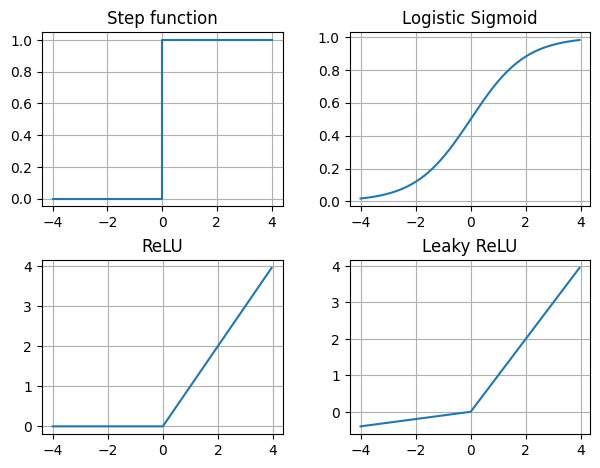

In [3]:
x = np.arange(-4, 4, 0.05)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.where(x>0,x,0)

def leaky_relu(x):
    return np.where(x>0,x,0.1*x)


fig, ax = plt.subplots(2, 2)
fig.tight_layout(pad=1.75)

ax[0, 0].grid()
ax[0, 0].plot([-4, 0, 0, 4], [0, 0, 1, 1])
ax[0, 0].set_title("Step function")

ax[0, 1].grid()
ax[0, 1].plot(x, sigmoid(x))
ax[0, 1].set_title("Logistic Sigmoid")

ax[1, 0].grid()
ax[1, 0].plot(x, relu(x))
ax[1, 0].set_title("ReLU")

ax[1, 1].grid()
ax[1, 1].plot(x, leaky_relu(x))
ax[1, 1].set_title("Leaky ReLU")

plt.show()

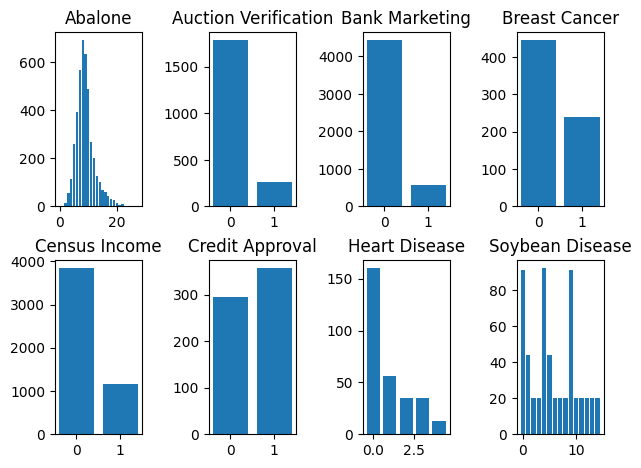

In [4]:
ds = load_all_datasets()

fig, ax = plt.subplots(2, 4)
fig.tight_layout(pad=1.75)

ax[0, 0].bar(*np.unique(ds[0].y, return_counts=True))
ax[0, 0].set_title(ds[0].name)
ax[0, 1].bar(*np.unique(ds[1].y, return_counts=True))
ax[0, 1].set_title(ds[1].name)
ax[0, 2].bar(*np.unique(ds[2].y, return_counts=True))
ax[0, 2].set_title(ds[2].name)
ax[0, 3].bar(*np.unique(ds[3].y, return_counts=True))
ax[0, 3].set_title(ds[3].name)
ax[1, 0].bar(*np.unique(ds[4].y, return_counts=True))
ax[1, 0].set_title(ds[4].name)
ax[1, 1].bar(*np.unique(ds[5].y, return_counts=True))
ax[1, 1].set_title(ds[5].name)
ax[1, 2].bar(*np.unique(ds[6].y, return_counts=True))
ax[1, 2].set_title(ds[6].name)
ax[1, 3].bar(*np.unique(ds[7].y, return_counts=True))
ax[1, 3].set_title(ds[7].name)

plt.show()

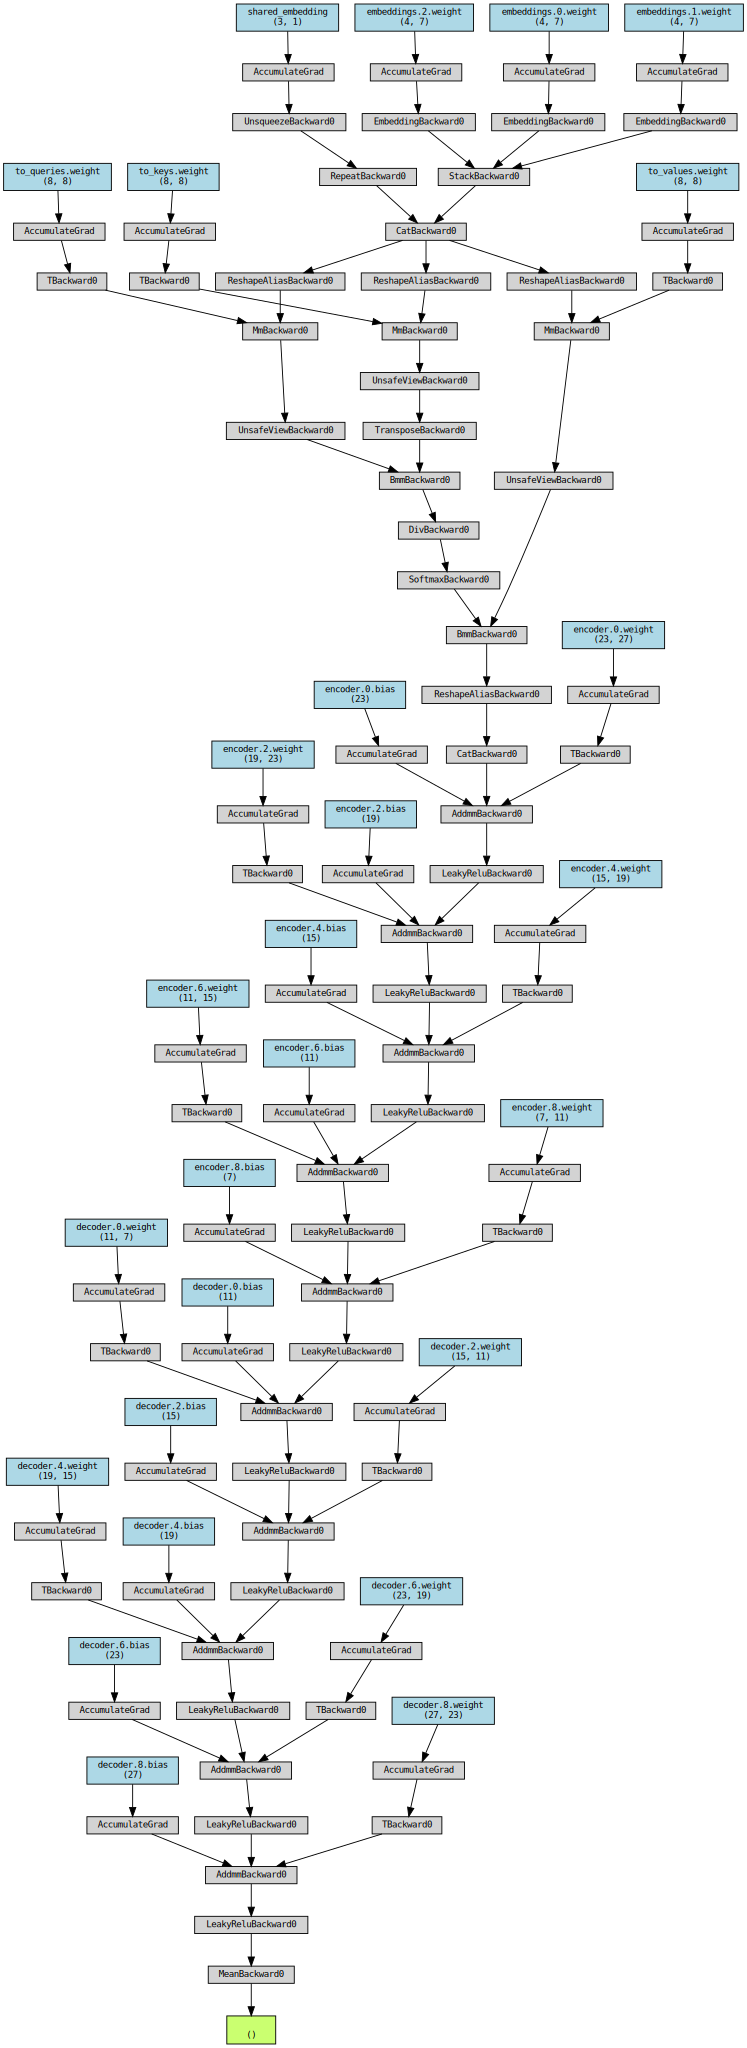

In [22]:
input_dim = 3 + 3 * 8
encoder, decoder = build_autoencoder(input_dim, input_dim, max(1, round(math.log2(input_dim))))

model = AttentionAutoencoder(encoder, decoder, [(4, 2), (4, 2), (4, 2)], emb_dim=8, device="cuda")
make_dot(model(torch.randint(0, 4, (1,3), device="cuda"), torch.rand(1, 3, device="cuda")).mean(), params=dict(model.named_parameters()))

In [14]:
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
np.random.seed(0)

credit_approval = load_all_datasets().credit_approval

In [23]:
# Basic AE
input_dim = sum(d for _, d in credit_approval.embedding_sizes) + len(credit_approval.cont_cols)
encoder, decoder = build_autoencoder(input_dim, input_dim, max(1, round(math.log2(input_dim))), hidden_dim=3, output_fn=torch.nn.Sigmoid)
print(encoder, decoder)

ae = AllToAllAutoencoder(encoder, decoder, credit_approval.embedding_sizes)
ae.fit(credit_approval.dataloader, n_epochs=100, lr=0.001)

cat = torch.tensor(credit_approval.df[credit_approval.cat_cols].values, dtype=torch.int).detach().to("cpu")
cont = torch.tensor(credit_approval.df[credit_approval.cont_cols].values, dtype=torch.float).detach().to("cpu")
basic_ae_features = ae.encode(cat, cont).detach().cpu().numpy()

Sequential(
  (0): Linear(in_features=28, out_features=23, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=23, out_features=18, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=18, out_features=13, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=13, out_features=8, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=8, out_features=3, bias=True)
  (9): Sigmoid()
) Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=8, out_features=13, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=13, out_features=18, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=18, out_features=23, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=23, out_features=28, bias=True)
  (9): Sigmoid()
)
Epoch 25/100 - Batch Reconstruction loss: 0.700048
Epoch 50/

In [25]:
# AE with Attention
input_dim = len(credit_approval.cont_cols) + len(credit_approval.cat_cols) * 32
encoder, decoder = build_autoencoder(input_dim, input_dim, max(1, round(math.log2(input_dim))), hidden_dim=3, output_fn=torch.nn.Sigmoid)
print(encoder, decoder)

ae = AttentionAutoencoder(encoder, decoder, credit_approval.embedding_sizes, emb_dim=32, device="cpu")
ae.fit(credit_approval.dataloader, n_epochs=100, lr=0.001)

cat = torch.tensor(credit_approval.df[credit_approval.cat_cols].values, dtype=torch.int).detach().to("cpu")
cont = torch.tensor(credit_approval.df[credit_approval.cont_cols].values, dtype=torch.float).detach().to("cpu")
attention_ae_features = ae.encode(cat, cont).detach().cpu().numpy()

Sequential(
  (0): Linear(in_features=294, out_features=258, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=258, out_features=222, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=222, out_features=186, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=186, out_features=150, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=150, out_features=114, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=114, out_features=78, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=78, out_features=42, bias=True)
  (13): LeakyReLU(negative_slope=0.01)
  (14): Linear(in_features=42, out_features=3, bias=True)
  (15): Sigmoid()
) Sequential(
  (0): Linear(in_features=3, out_features=42, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=42, out_features=78, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_fea

In [26]:
# AE with Transformer
input_dim = len(credit_approval.cont_cols) + len(credit_approval.cat_cols) * 32
encoder, decoder = build_autoencoder(input_dim, input_dim, max(1, round(math.log2(input_dim))), hidden_dim=3, output_fn=torch.nn.Sigmoid)
print(encoder, decoder)

ae = TransformerAutoencoder(encoder, decoder, credit_approval.embedding_sizes, emb_dim=32, depth=6, device="cpu")
ae.fit(credit_approval.dataloader, n_epochs=100, lr=0.001)

cat = torch.tensor(credit_approval.df[credit_approval.cat_cols].values, dtype=torch.int).detach().to("cpu")
cont = torch.tensor(credit_approval.df[credit_approval.cont_cols].values, dtype=torch.float).detach().to("cpu")
transformer_ae_features = ae.encode(cat, cont).detach().cpu().numpy()

Sequential(
  (0): Linear(in_features=294, out_features=258, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=258, out_features=222, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=222, out_features=186, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=186, out_features=150, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=150, out_features=114, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=114, out_features=78, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=78, out_features=42, bias=True)
  (13): LeakyReLU(negative_slope=0.01)
  (14): Linear(in_features=42, out_features=3, bias=True)
  (15): Sigmoid()
) Sequential(
  (0): Linear(in_features=3, out_features=42, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=42, out_features=78, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_fea

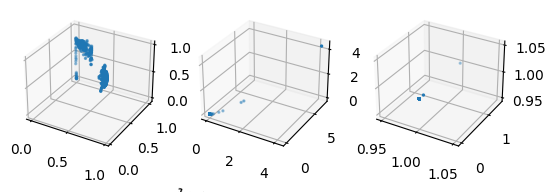

In [28]:
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection="3d"))

ax[0].scatter3D(basic_ae_features[:, 0], basic_ae_features[:, 1], basic_ae_features[:, 2], s=2)
ax[1].scatter3D(attention_ae_features[:, 0], attention_ae_features[:, 1], attention_ae_features[:, 2], s=2)
ax[2].scatter3D(transformer_ae_features[:, 0], transformer_ae_features[:, 1], transformer_ae_features[:, 2], s=2)

plt.show()